# Analyze the 25 features for density plots over two classes

In [2]:
# import stuff
import os
import pandas as pd
from sklearn.datasets import load_svmlight_file, dump_svmlight_file
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import operator

## Regularly Trained Model Feature Importance

In [7]:
#allnames = "EntryURLiw, EntryURLid, AvgURLiw, AvgURLid, ChainWeight, CCsize, CCdensity, MaxRCLen, MinRCLen, MaxRCLen, MinRCLen, MaxLdURLDom, AvgLdURLDom, CntInitURL, CntInitURLDom, CntLdURL, MaxIPperURL, AvgIPperURL, MaxIPperLdURL, AvgIPperLdURL, GeoDist, MaxGeoDist, XContinentHops, CntContinent, XCountryHops, CntCountry, XIPHops, CntIP, XDomainHops, CntDomain, XTLD, CntTLD, ChainLen, EntryURLDist, at_cnt, hashtag_cnt, user_tweetcnt, user_percent"
#allnames = "EntryURLiw, EntryURLid, AvgURLiw, AvgURLid, ChainWeight, CCsize, CCdensity, MaxRCLen, MinRCLen, MaxLdURLDom, AvgLdURLDom, MaxURLDom, AvgURLDom, GeoDist, MaxGeoDist, XContinentHops, CntContinent, XCountryHops, CntCountry, XIPHops, CntIP, XDomainHops, CntDomain, XTLD, CntTLD, ChainLen, EntryURLDist, CntInitURL, CntInitURLDom, CntLdURL, MaxIPperURL, AvgIPperURL, MaxIPperLdURL, AvgIPperLdURL, at_cnt, hashtag_cnt, user_tweetcnt, user_percent"
allnames = "EntryURLid, AvgURLid, ChainWeight, CCsize, CCdensity, MinRCLen, AvgLdURLDom, AvgURLDom, GeoDist, CntContinent, CntCountry, CntIP, CntDomain, CntTLD, ChainLen, EntryURLDist, CntInitURL, CntInitURLDom, CntLdURL, AvgIPperURL, AvgIPperLdURL, at_cnt, hashtag_cnt, user_tweetcnt, user_percent"
feat_names = allnames.split(', ')
#for name in feat_names:
#    print("'"+name+"': ,")
print(len(feat_names))


25


In [149]:
model_path = '../models_csv/gbdt/nature/nature_twitter_spam.bin'

model = xgb.Booster()
model.load_model(model_path)

def get_xgb_imp(model, feat_names):
    imp_vals = model.get_fscore()
    #print(imp_vals)
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    #print(imp_dict)
    total = np.sum(list(imp_dict.values()))
    #print(total)
    return {k:v/total for k,v in imp_dict.items()}
feat_imp = get_xgb_imp(model, feat_names)
sorted_feat_imp = sorted(feat_imp.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_feat_imp)
print(len(sorted_feat_imp))

[('user_tweetcnt', 0.32093466857415354), ('hashtag_cnt', 0.09346685741535526), ('ChainWeight', 0.06151645207439199), ('AvgURLDom', 0.04196471149260849), ('MaxLdURLDom', 0.04005722460658083), ('AvgIPperURL', 0.039103481163567), ('EntryURLiw', 0.03528850739151168), ('MaxURLDom', 0.030996661897949453), ('AvgURLiw', 0.030519790176442536), ('CntInitURL', 0.02670481640438722), ('CntInitURLDom', 0.02670481640438722), ('CCsize', 0.02575107296137339), ('at_cnt', 0.023843586075345733), ('AvgLdURLDom', 0.022889842632331903), ('GeoDist', 0.0195517405817835), ('MaxIPperLdURL', 0.017167381974248927), ('MinRCLen', 0.016213638531235097), ('EntryURLid', 0.015259895088221268), ('MaxRCLen', 0.01239866475917978), ('AvgURLid', 0.011921793037672867), ('CCdensity', 0.011921793037672867), ('XIPHops', 0.011921793037672867), ('CntTLD', 0.011921793037672867), ('MaxGeoDist', 0.011444921316165951), ('XDomainHops', 0.00715307582260372), ('EntryURLDist', 0.00619933237958989), ('CntIP', 0.005245588936576061), ('XTLD'

In [150]:
# get index of the most important features
#for feat in ['user_tweetcnt', 'hashtag_cnt', 'ChainWeight', 'AvgLdURLDom', 'MaxLdURLDom', 'AvgIPperURL',\
#             'MaxURLDom', 'CntInitURLDom', 'AvgURLiw', 'CCsize', 'CntInitURL', 'AvgLdURLDom', 'at_cnt']:
for pair in sorted_feat_imp:
    feat = pair[0]
    print(feat, 'f'+str(feat_names.index(feat)))


user_tweetcnt f36
hashtag_cnt f35
ChainWeight f4
AvgURLDom f12
MaxLdURLDom f9
AvgIPperURL f31
EntryURLiw f0
MaxURLDom f11
AvgURLiw f2
CntInitURL f27
CntInitURLDom f28
CCsize f5
at_cnt f34
AvgLdURLDom f10
GeoDist f13
MaxIPperLdURL f32
MinRCLen f8
EntryURLid f1
MaxRCLen f7
AvgURLid f3
CCdensity f6
XIPHops f19
CntTLD f24
MaxGeoDist f14
XDomainHops f21
EntryURLDist f26
CntIP f20
XTLD f23
AvgIPperLdURL f33
MaxIPperURL f30
CntLdURL f29
CntCountry f18
CntContinent f16
CntDomain f22
XCountryHops f17
user_percent f37
XContinentHops f15
ChainLen f25


In [10]:
# read init node label
data_path = '/Users/yz/Documents/data/Twitter-RCG'
nid_label = {}
with open(os.path.join(data_path, 'InitNodeType1.csv'), 'r') as f:
    for line in f:
        nid, label = line.rstrip().split(',')
        nid_label[nid] = label

# read features
features = []
all_labels = []
seen = set([])
with open('features_dedup.csv', 'r') as f:
    for line in f:
        fields = line.rstrip().split(',')
        init_nid = fields[1]
        if init_nid in seen:
            continue
        seen.add(init_nid)
        # dedup and take the init_nid once.
        if nid_label[init_nid] == '-1':
            label = 1 # malicious
        else:
            label = 0
        all_labels.append(label)
        # 18 dimensions
        features.append([float(item) for item in fields[2:]])

# features, all_labels
features = np.array(features)
all_labels = np.array(all_labels)
print(features.shape)
print(all_labels.shape)

(422672, 25)
(422672,)


### Spam users tend to send fewer tweets to maintain low profil

(186526, 38) (236146, 38)
Feature # 36 user_tweetcnt


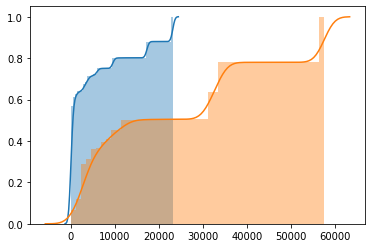

In [58]:
feat_index = 36
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
sns.distplot(negative_df[['Value']], label="Benign", hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 36 user_tweetcnt


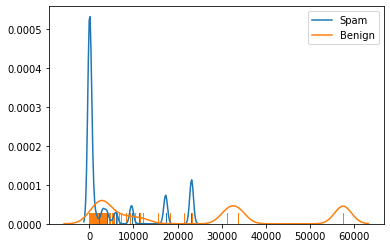

In [6]:
feat_index = 36
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 35 hashtag_cnt


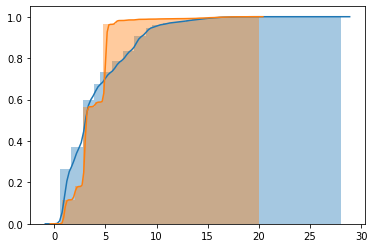

In [59]:
feat_index = 35
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
sns.distplot(negative_df[['Value']], label="Benign", hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 4 ChainWeight


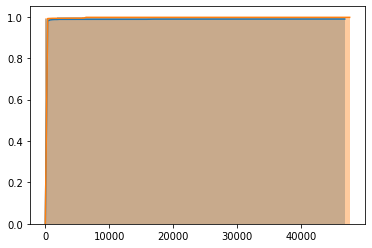

In [60]:
feat_index = 4
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
sns.distplot(negative_df[['Value']], label="Benign", hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 12 AvgURLDom


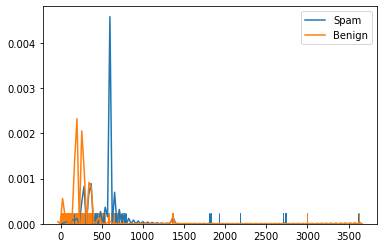

In [122]:
feat_index = 12
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 12 AvgURLDom


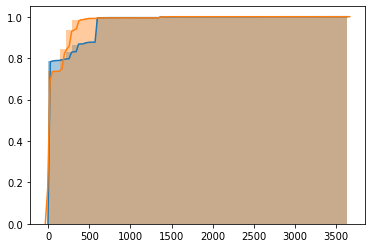

In [61]:
feat_index = 12
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
sns.distplot(negative_df[['Value']], label="Benign", hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 9 MaxLdURLDom


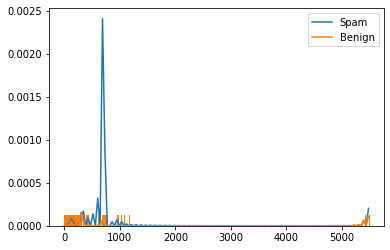

In [62]:
feat_index = 9
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 9 MaxLdURLDom


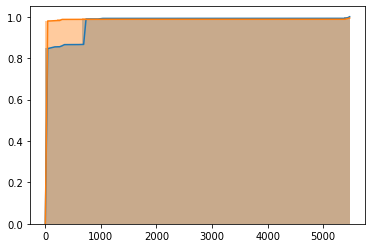

In [121]:
feat_index = 9
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
sns.distplot(negative_df[['Value']], label="Benign", hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 31 AvgIPperURL


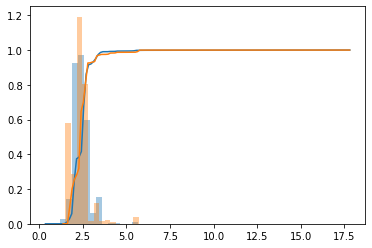

In [115]:
feat_index = 31
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", kde_kws={'cumulative': True})
sns.distplot(negative_df[['Value']], label="Benign", kde_kws={'cumulative': True})
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 0 EntryURLiw


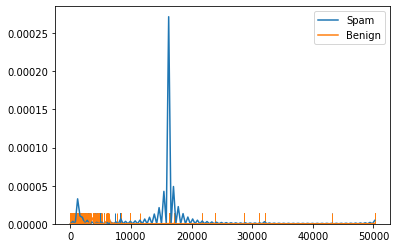

In [66]:
feat_index = 0
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 11 MaxURLDom


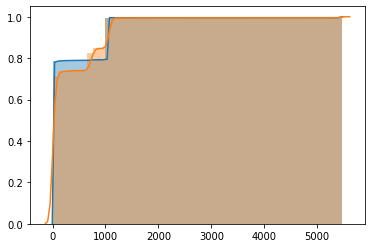

In [64]:
feat_index = 11
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
sns.distplot(negative_df[['Value']], label="Benign", hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 16 CntContinent


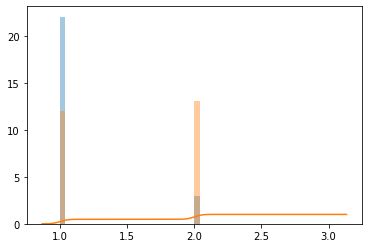

In [68]:
feat_index = 16
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", kde_kws={'cumulative': True})
sns.distplot(negative_df[['Value']], label="Benign", kde_kws={'cumulative': True})
#sns.plt.show()
#sns.plt.legend()

(186526, 40) (236146, 40)
Feature # 2 AvgURLiw


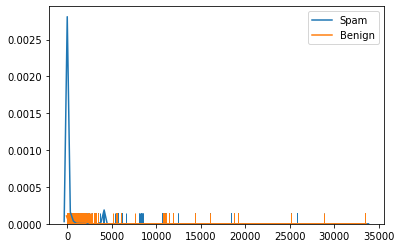

In [31]:
feat_index = 2
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, 'AvgURLiw')
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 40) (236146, 40)
Feature # 5 CCsize


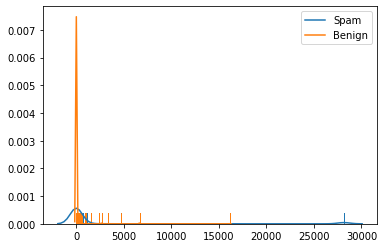

In [32]:
feat_index = 5
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, 'CCsize')
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

## Shared resources

(186526, 25) (236146, 25)
Feature # 0 EntryURLid


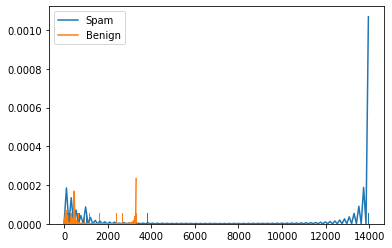

In [11]:
feat_index = 0
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 1 AvgURLid


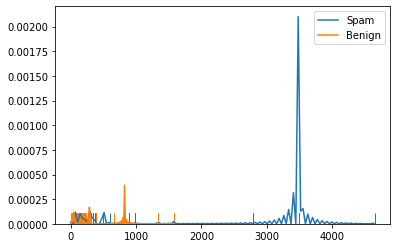

In [12]:
feat_index = 1
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 2 ChainWeight


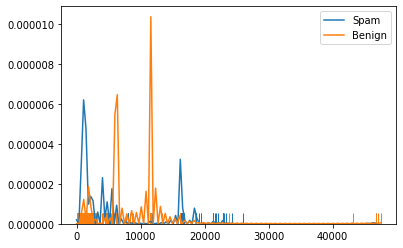

In [13]:
feat_index = 2
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 3 CCsize


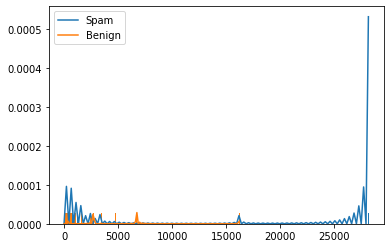

In [14]:
feat_index = 3
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 4 CCdensity


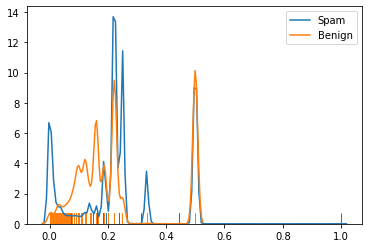

In [15]:
feat_index = 4
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 5 MinRCLen


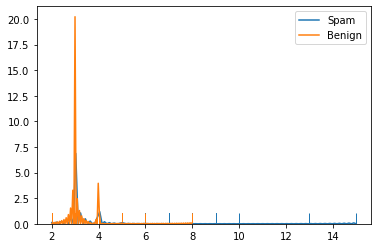

In [16]:
feat_index = 5
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 6 AvgLdURLDom


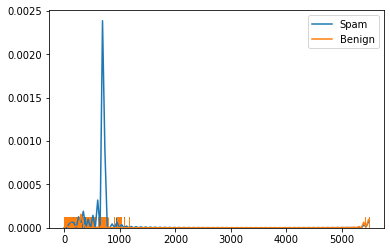

In [17]:
feat_index = 6
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 7 AvgURLDom


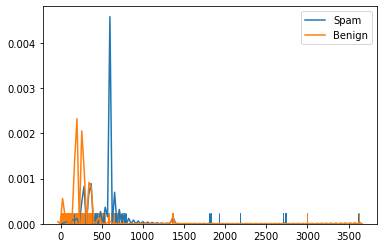

In [18]:
feat_index = 7
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 8 GeoDist


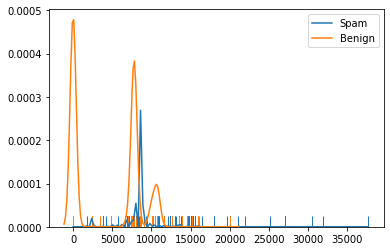

In [19]:
feat_index = 8
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 9 CntContinent


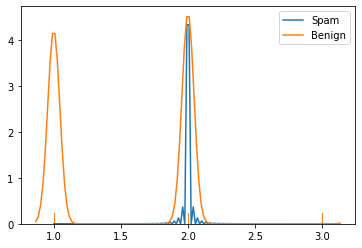

In [20]:
feat_index = 9
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 10 CntCountry


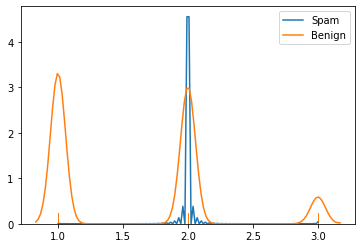

In [21]:
feat_index = 10
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 11 CntIP


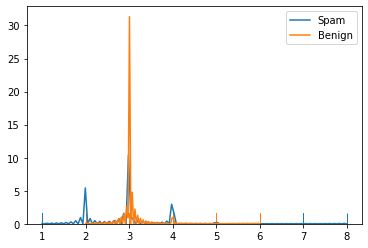

In [22]:
feat_index = 11
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 12 CntDomain


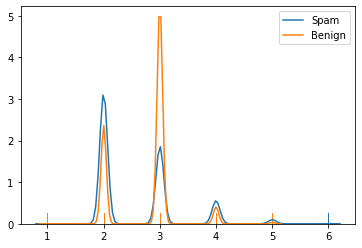

In [23]:
feat_index = 12
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 13 CntTLD


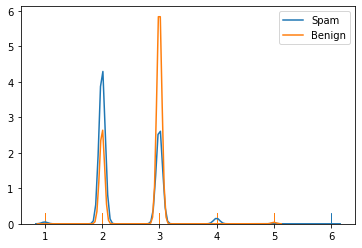

In [24]:
feat_index = 13
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 14 ChainLen


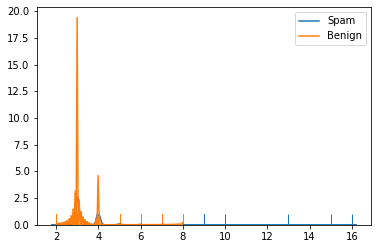

In [25]:
feat_index = 14
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 15 EntryURLDist


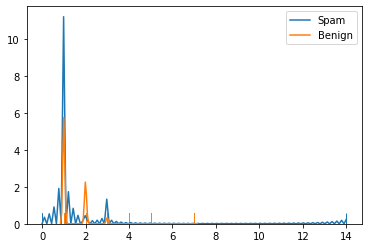

In [26]:
feat_index = 15
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 16 CntInitURL


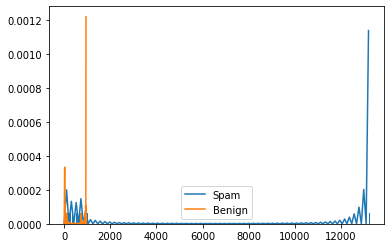

In [27]:
feat_index = 16
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 17 CntInitURLDom


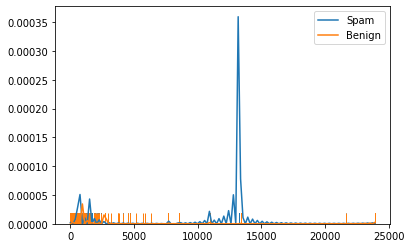

In [28]:
feat_index = 17
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 18 CntLdURL


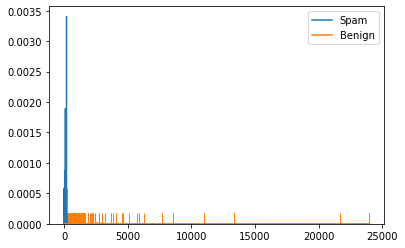

In [29]:
feat_index = 18
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 19 AvgIPperURL


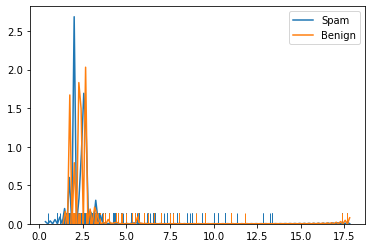

In [30]:
feat_index = 19
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 20 AvgIPperLdURL


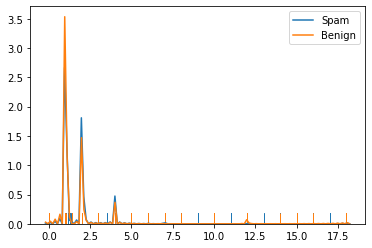

In [31]:
feat_index = 20
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 21 at_cnt


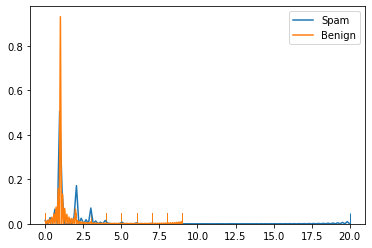

In [32]:
feat_index = 21
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 22 hashtag_cnt


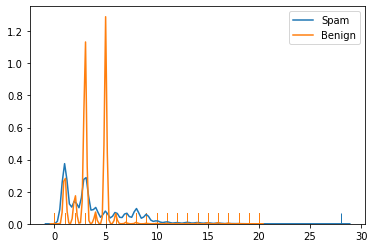

In [33]:
feat_index = 22
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 23 user_tweetcnt


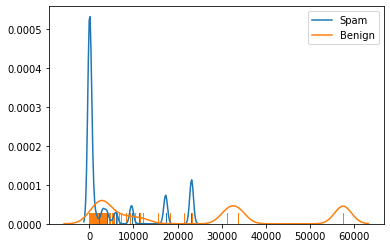

In [34]:
feat_index = 23
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)
Feature # 24 user_percent


/Users/yz/Envs/trees/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/yz/Envs/trees/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


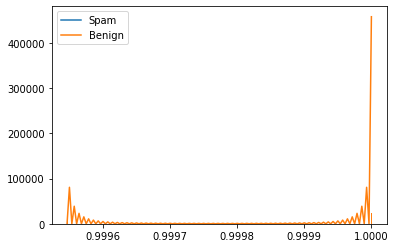

In [35]:
feat_index = 24
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

# End of reduced features.

In [36]:
feat_index = 25
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 25) (236146, 25)


IndexError: list index out of range

(186526, 38) (236146, 38)
Feature # 26 EntryURLDist


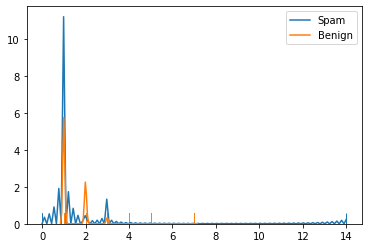

In [99]:
feat_index = 26
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 27 CntInitURL


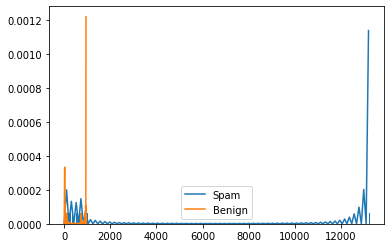

In [100]:
feat_index = 27
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 28 CntInitURLDom


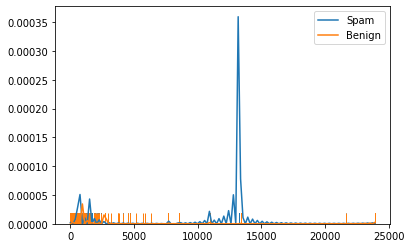

In [101]:
feat_index = 28
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 29 CntLdURL


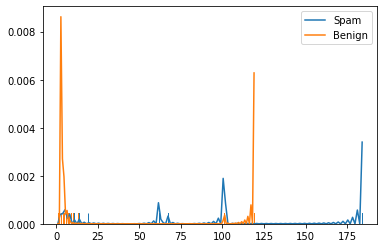

In [102]:
feat_index = 29
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 30 MaxIPperURL


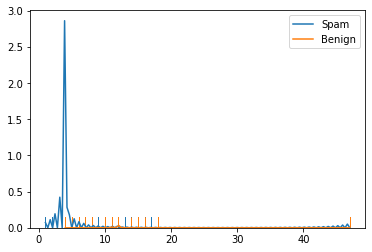

In [103]:
feat_index = 30
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 31 AvgIPperURL


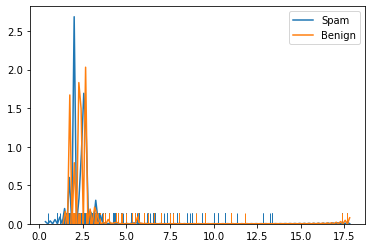

In [104]:
feat_index = 31
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 32 MaxIPperLdURL


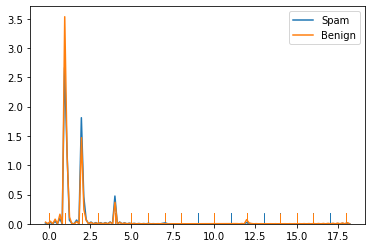

In [105]:
feat_index = 32
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 33 AvgIPperLdURL


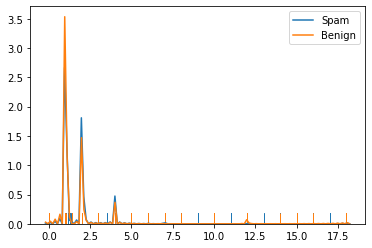

In [106]:
feat_index = 33
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 34 at_cnt


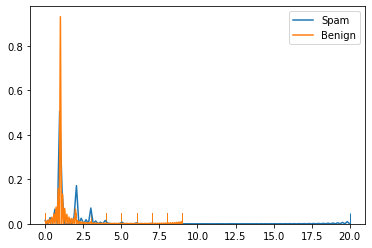

In [107]:
feat_index = 34
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 35 hashtag_cnt


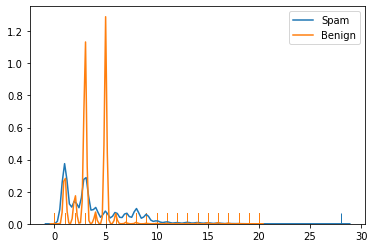

In [108]:
feat_index = 35
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 36 user_tweetcnt


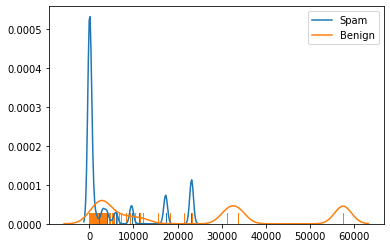

In [109]:
feat_index = 36
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

(186526, 38) (236146, 38)
Feature # 37 user_percent


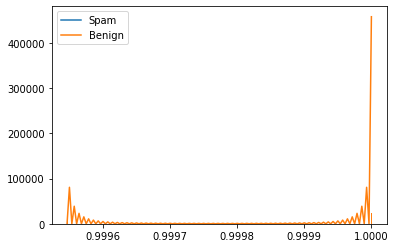

In [110]:
feat_index = 37
# positive and negative classes
positive_features = features[all_labels==1, :]
negative_features = features[all_labels==0, :]
print(positive_features.shape, negative_features.shape)
# test the first feature dimension
print("Feature #", feat_index, feat_names[feat_index])
df = pd.DataFrame({'Value':features[:, feat_index], 'Class':all_labels})

# Sort the dataframe by target
positive_df = df.loc[df['Class'] == 1]
negative_df = df.loc[df['Class'] == 0]
sns.distplot(positive_df[['Value']], label="Spam", hist=False, rug=True)
sns.distplot(negative_df[['Value']], label="Benign", hist=False, rug=True)
#sns.plt.show()
#sns.plt.legend()

## Greedy model feature importance

In [154]:
model_path = '../models_csv/gbdt/flex/flex_twitter_spam_v8_nt150d24.bin'

model = xgb.Booster()
model.load_model(model_path)

def get_xgb_imp(model, feat_names):
    imp_vals = model.get_fscore()
    #print(imp_vals)
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    #print(imp_dict)
    total = np.sum(list(imp_dict.values()))
    #print(total)
    return {k:v/total for k,v in imp_dict.items()}
feat_imp = get_xgb_imp(model, feat_names)
sorted_feat_imp = sorted(feat_imp.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_feat_imp)
print(len(sorted_feat_imp))

[('AvgURLDom', 0.13204660677755048), ('user_tweetcnt', 0.10906341723739216), ('AvgLdURLDom', 0.09170150315752024), ('AvgURLid', 0.08828604465000445), ('EntryURLid', 0.07350351329716268), ('hashtag_cnt', 0.05872098194432091), ('MaxLdURLDom', 0.05514542381926532), ('MaxURLDom', 0.05430934803877969), ('ChainWeight', 0.044116339055412256), ('CCdensity', 0.03529307124432981), ('MaxGeoDist', 0.034190162767944496), ('AvgURLiw', 0.02926265231699724), ('EntryURLiw', 0.026096237658987814), ('at_cnt', 0.021915858756559638), ('CntInitURLDom', 0.020332651427554922), ('CCsize', 0.0173263363870853), ('GeoDist', 0.01647247176020635), ('AvgIPperURL', 0.01645468291381304), ('MaxIPperLdURL', 0.013608467490883217), ('CntInitURL', 0.010104064751400871), ('AvgIPperLdURL', 0.00688428355421151), ('CntTLD', 0.005247709686026861), ('CntDomain', 0.004802988526194076), ('MaxRCLen', 0.004429422751934537), ('EntryURLDist', 0.004144801209641555), ('CntIP', 0.0037712354353820155), ('MinRCLen', 0.0030418927332562483),

user_tweetcnt f36
hashtag_cnt f35
MaxURLDom f11
ChainWeight f4
AvgURLDom f12
EntryURLid f1
AvgURLid f3
MaxGeoDist f14
CCdensity f6
AvgURLiw f2
CntInitURLDom f28
EntryURLiw f0
MaxIPperLdURL f32
MaxLdURLDom f9
CCsize f5
AvgIPperURL f31
at_cnt f34
AvgLdURLDom f10
AvgIPperLdURL f33
CntCountry f18
CntTLD f24
CntDomain f22
CntContinent f16
GeoDist f13
MaxRCLen f7
CntLdURL f29
XContinentHops f15
MaxIPperURL f30
CntInitURL f27
MinRCLen f8
XTLD f23
CntIP f20
ChainLen f25
EntryURLDist f26
XCountryHops f17
XDomainHops f21
XIPHops f19
user_percent f37


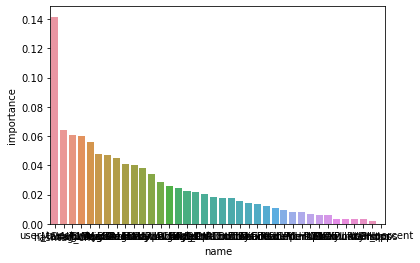

In [158]:
# get index of the most important features
#for feat in ['user_tweetcnt', 'hashtag_cnt', 'ChainWeight', 'AvgLdURLDom', 'MaxLdURLDom', 'AvgIPperURL',\
#             'MaxURLDom', 'CntInitURLDom', 'AvgURLiw', 'CCsize', 'CntInitURL', 'AvgLdURLDom', 'at_cnt']:
for pair in sorted_feat_imp:
    feat = pair[0]
    print(feat, 'f'+str(feat_names.index(feat)))
    
df = pd.DataFrame({'name':[item[0] for item in sorted_feat_imp], 'importance':[item[1] for item in sorted_feat_imp]})
sns.barplot(x="name", y="importance", data=df)

In [169]:
model_path = '../models_csv/gbdt/flex/flex_twitter_spam_v12_nt150d24.bin'

model = xgb.Booster()
model.load_model(model_path)

def get_xgb_imp(model, feat_names):
    imp_vals = model.get_fscore()
    #print(imp_vals)
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    #print(imp_dict)
    total = np.sum(list(imp_dict.values()))
    #print(total)
    return {k:v/total for k,v in imp_dict.items()}
feat_imp = get_xgb_imp(model, feat_names)
sorted_feat_imp = sorted(feat_imp.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_feat_imp)
print(len(sorted_feat_imp))
# get index of the most important features
#for feat in ['user_tweetcnt', 'hashtag_cnt', 'ChainWeight', 'AvgLdURLDom', 'MaxLdURLDom', 'AvgIPperURL',\
#             'MaxURLDom', 'CntInitURLDom', 'AvgURLiw', 'CCsize', 'CntInitURL', 'AvgLdURLDom', 'at_cnt']:
for pair in sorted_feat_imp:
    feat = pair[0]
    print(feat, 'f'+str(feat_names.index(feat)))

[('CntDomain', 0.3323649041255084), ('CCsize', 0.2117954677513074), ('AvgURLid', 0.10604299825682742), ('AvgLdURLDom', 0.09877977919814061), ('CntIP', 0.0778617083091226), ('CCdensity', 0.03631609529343405), ('CntContinent', 0.02876234747239977), ('CntCountry', 0.02266124346310285), ('CntTLD', 0.01656013945380593), ('ChainWeight', 0.01452643811737362), ('EntryURLid', 0.01336432306798373), ('MinRCLen', 0.008715862870424172), ('ChainLen', 0.005810575246949448), ('hashtag_cnt', 0.004357931435212086), ('AvgURLDom', 0.002905287623474724), ('at_cnt', 0.002905287623474724), ('CntInitURL', 0.0026147588611272515), ('AvgIPperLdURL', 0.002324230098779779), ('user_tweetcnt', 0.002324230098779779), ('GeoDist', 0.0020337013364323067), ('CntLdURL', 0.0020337013364323067), ('AvgIPperURL', 0.0020337013364323067), ('CntInitURLDom', 0.0017431725740848344), ('user_percent', 0.0008715862870424172), ('EntryURLDist', 0.0002905287623474724)]
25
CntDomain f12
CCsize f3
AvgURLid f1
AvgLdURLDom f6
CntIP f11
CCde

In [170]:
# 25 features
allnames = "EntryURLid, AvgURLid, ChainWeight, CCsize, CCdensity, MinRCLen, AvgLdURLDom, AvgURLDom, GeoDist, CntContinent, CntCountry, CntIP, CntDomain, CntTLD, ChainLen, EntryURLDist, CntInitURL, CntInitURLDom, CntLdURL, AvgIPperURL, AvgIPperLdURL, at_cnt, hashtag_cnt, user_tweetcnt, user_percent"
feat_names = allnames.split(', ')

model_path = '../models_csv/gbdt/nature/nature_twitter_spam_reduced.bin'

model = xgb.Booster()
model.load_model(model_path)

def get_xgb_imp(model, feat_names):
    imp_vals = model.get_fscore()
    #print(imp_vals)
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    #print(imp_dict)
    total = np.sum(list(imp_dict.values()))
    #print(total)
    return {k:v/total for k,v in imp_dict.items()}
feat_imp = get_xgb_imp(model, feat_names)
sorted_feat_imp = sorted(feat_imp.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_feat_imp)
print(len(sorted_feat_imp))
# get index of the most important features
#for feat in ['user_tweetcnt', 'hashtag_cnt', 'ChainWeight', 'AvgLdURLDom', 'MaxLdURLDom', 'AvgIPperURL',\
#             'MaxURLDom', 'CntInitURLDom', 'AvgURLiw', 'CCsize', 'CntInitURL', 'AvgLdURLDom', 'at_cnt']:
for pair in sorted_feat_imp:
    feat = pair[0]
    print(feat, 'f'+str(feat_names.index(feat)))

[('user_tweetcnt', 0.3469018543645409), ('hashtag_cnt', 0.08864767073722297), ('ChainWeight', 0.07507914970601538), ('AvgLdURLDom', 0.07372229760289462), ('AvgURLDom', 0.06829488919041157), ('CntInitURLDom', 0.045228403437358664), ('AvgIPperURL', 0.04296698326549073), ('CntInitURL', 0.032564450474898234), ('EntryURLid', 0.02939846223428313), ('CCsize', 0.02532790592492085), ('GeoDist', 0.023518769787426504), ('at_cnt', 0.023066485753052916), ('AvgURLid', 0.020805065581184983), ('CntIP', 0.01990049751243781), ('MinRCLen', 0.01854364540931705), ('CntTLD', 0.015829941203075532), ('AvgIPperLdURL', 0.013568521031207599), ('CCdensity', 0.009045680687471733), ('CntDomain', 0.008141112618724558), ('ChainLen', 0.007688828584350972), ('EntryURLDist', 0.007688828584350972), ('CntLdURL', 0.0018091361374943465), ('CntContinent', 0.0013568521031207597), ('CntCountry', 0.0009045680687471732), ('user_percent', 0.0)]
25
user_tweetcnt f23
hashtag_cnt f22
ChainWeight f2
AvgLdURLDom f6
AvgURLDom f7
CntIni

In [1]:
# 25 features
allnames = "EntryURLid, AvgURLid, ChainWeight, CCsize, CCdensity, MinRCLen, AvgLdURLDom, AvgURLDom, GeoDist, CntContinent, CntCountry, CntIP, CntDomain, CntTLD, ChainLen, EntryURLDist, CntInitURL, CntInitURLDom, CntLdURL, AvgIPperURL, AvgIPperLdURL, at_cnt, hashtag_cnt, user_tweetcnt, user_percent"
feat_names = allnames.split(', ')

model_path = '../models_csv/gbdt/flex/flex_twitter_spam_v14_nt150d24.bin'

model = xgb.Booster()
model.load_model(model_path)

def get_xgb_imp(model, feat_names):
    imp_vals = model.get_fscore()
    #print(imp_vals)
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    #print(imp_dict)
    total = np.sum(list(imp_dict.values()))
    #print(total)
    return {k:v/total for k,v in imp_dict.items()}
feat_imp = get_xgb_imp(model, feat_names)
sorted_feat_imp = sorted(feat_imp.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_feat_imp)
print(len(sorted_feat_imp))
# get index of the most important features
#for feat in ['user_tweetcnt', 'hashtag_cnt', 'ChainWeight', 'AvgLdURLDom', 'MaxLdURLDom', 'AvgIPperURL',\
#             'MaxURLDom', 'CntInitURLDom', 'AvgURLiw', 'CCsize', 'CntInitURL', 'AvgLdURLDom', 'at_cnt']:
for pair in sorted_feat_imp:
    feat = pair[0]
    print(feat, 'f'+str(feat_names.index(feat)))

NameError: name 'xgb' is not defined

In [177]:
model_path = '../models_csv/gbdt/flex/flex_twitter_spam_v16_nt150d24.bin'

model = xgb.Booster()
model.load_model(model_path)

def get_xgb_imp(model, feat_names):
    imp_vals = model.get_fscore()
    #print(imp_vals)
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    #print(imp_dict)
    total = np.sum(list(imp_dict.values()))
    #print(total)
    return {k:v/total for k,v in imp_dict.items()}
feat_imp = get_xgb_imp(model, feat_names)
sorted_feat_imp = sorted(feat_imp.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_feat_imp)
print(len(sorted_feat_imp))
# get index of the most important features
#for feat in ['user_tweetcnt', 'hashtag_cnt', 'ChainWeight', 'AvgLdURLDom', 'MaxLdURLDom', 'AvgIPperURL',\
#             'MaxURLDom', 'CntInitURLDom', 'AvgURLiw', 'CCsize', 'CntInitURL', 'AvgLdURLDom', 'at_cnt']:
for pair in sorted_feat_imp:
    feat = pair[0]
    print(feat, 'f'+str(feat_names.index(feat)))

[('AvgLdURLDom', 0.2829612723771486), ('user_tweetcnt', 0.1398473717994437), ('hashtag_cnt', 0.0834747878182726), ('CCdensity', 0.07765494615220027), ('AvgURLDom', 0.06416090150488553), ('ChainWeight', 0.051865059553526854), ('GeoDist', 0.04590257470936453), ('AvgURLid', 0.04480422223807146), ('EntryURLid', 0.028785393338563583), ('CCsize', 0.02708793951929249), ('AvgIPperLdURL', 0.026873974752157477), ('at_cnt', 0.021353683760074176), ('CntInitURLDom', 0.02125383353541117), ('AvgIPperURL', 0.020440767420298125), ('CntInitURL', 0.013536837600741744), ('CntIP', 0.009428714071749519), ('CntTLD', 0.009157692033378503), ('MinRCLen', 0.008672705227872477), ('ChainLen', 0.008273304329220455), ('CntDomain', 0.006347621425005349), ('EntryURLDist', 0.0045360530632622496), ('CntLdURL', 0.0020825904001141146), ('CntCountry', 0.0006561586192140361), ('user_percent', 0.0005563083945510306), ('CntContinent', 0.0002852863561800157)]
25
AvgLdURLDom f6
user_tweetcnt f23
hashtag_cnt f22
CCdensity f4
Avg

In [179]:
model_path = '../models_csv/gbdt/flex/flex_twitter_spam_v17_nt150d24.bin'

model = xgb.Booster()
model.load_model(model_path)

def get_xgb_imp(model, feat_names):
    imp_vals = model.get_fscore()
    #print(imp_vals)
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    #print(imp_dict)
    total = np.sum(list(imp_dict.values()))
    #print(total)
    return {k:v/total for k,v in imp_dict.items()}
feat_imp = get_xgb_imp(model, feat_names)
sorted_feat_imp = sorted(feat_imp.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_feat_imp)
print(len(sorted_feat_imp))
# get index of the most important features
#for feat in ['user_tweetcnt', 'hashtag_cnt', 'ChainWeight', 'AvgLdURLDom', 'MaxLdURLDom', 'AvgIPperURL',\
#             'MaxURLDom', 'CntInitURLDom', 'AvgURLiw', 'CCsize', 'CntInitURL', 'AvgLdURLDom', 'at_cnt']:
for pair in sorted_feat_imp:
    feat = pair[0]
    print(feat, 'f'+str(feat_names.index(feat)))

[('user_tweetcnt', 0.2177121771217712), ('GeoDist', 0.1261201897733263), ('AvgURLDom', 0.09857670005271481), ('hashtag_cnt', 0.08623264804076612), ('AvgLdURLDom', 0.08060973466877526), ('CCdensity', 0.07696362677912494), ('ChainWeight', 0.045290810050957656), ('AvgURLid', 0.03562642769284836), ('CntInitURLDom', 0.03457213143560007), ('AvgIPperURL', 0.03391319627481989), ('AvgIPperLdURL', 0.030794236513793708), ('at_cnt', 0.02727991565629942), ('CCsize', 0.025083465120365488), ('EntryURLid', 0.024204884905991916), ('CntInitURL', 0.01300298717272887), ('CntIP', 0.009532595325953259), ('CntTLD', 0.007775434897206115), ('CntLdURL', 0.007643647865050079), ('CntDomain', 0.005842558425584256), ('ChainLen', 0.004788262168335969), ('MinRCLen', 0.0033386048146195747), ('EntryURLDist', 0.0022403795466526093), ('CntCountry', 0.0018450184501845018), ('CntContinent', 0.0008785802143735723), ('user_percent', 0.00013178703215603585)]
25
user_tweetcnt f23
GeoDist f8
AvgURLDom f7
hashtag_cnt f22
AvgLdUR

In [182]:
model_path = '../models_csv/gbdt/flex/flex_twitter_spam_v19_nt150d24.bin'

model = xgb.Booster()
model.load_model(model_path)

def get_xgb_imp(model, feat_names):
    imp_vals = model.get_fscore()
    #print(imp_vals)
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    #print(imp_dict)
    total = np.sum(list(imp_dict.values()))
    #print(total)
    return {k:v/total for k,v in imp_dict.items()}
feat_imp = get_xgb_imp(model, feat_names)
sorted_feat_imp = sorted(feat_imp.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_feat_imp)
print(len(sorted_feat_imp))
# get index of the most important features
#for feat in ['user_tweetcnt', 'hashtag_cnt', 'ChainWeight', 'AvgLdURLDom', 'MaxLdURLDom', 'AvgIPperURL',\
#             'MaxURLDom', 'CntInitURLDom', 'AvgURLiw', 'CCsize', 'CntInitURL', 'AvgLdURLDom', 'at_cnt']:
for pair in sorted_feat_imp:
    feat = pair[0]
    print(feat, 'f'+str(feat_names.index(feat)))

[('user_tweetcnt', 0.15055908129344212), ('AvgURLDom', 0.09265639165911152), ('GeoDist', 0.09132668479903294), ('AvgIPperLdURL', 0.0889694771834391), ('hashtag_cnt', 0.07796917497733455), ('ChainWeight', 0.06841946207313387), ('CCdensity', 0.06576004835297673), ('AvgURLid', 0.050649743124811124), ('CntInitURLDom', 0.041100030220610456), ('at_cnt', 0.035297673012994864), ('AvgLdURLDom', 0.03402840737382895), ('EntryURLid', 0.033303112722877004), ('AvgIPperURL', 0.03306134783922635), ('CCsize', 0.03203384708371109), ('CntInitURL', 0.01656089453006951), ('CntCountry', 0.016016923541855545), ('CntContinent', 0.0119069205197945), ('CntTLD', 0.01166515563614385), ('CntDomain', 0.010154125113327288), ('CntLdURL', 0.009187065578724691), ('CntIP', 0.009005741915986703), ('MinRCLen', 0.007313387730432155), ('ChainLen', 0.0071925052886068295), ('EntryURLDist', 0.005862798428528256), ('user_percent', 0.0)]
25
user_tweetcnt f23
AvgURLDom f7
GeoDist f8
AvgIPperLdURL f20
hashtag_cnt f22
ChainWeight f

In [2]:
allnames = "EntryURLid, AvgURLid, ChainWeight, CCsize, CCdensity, MinRCLen, AvgLdURLDom, AvgURLDom, GeoDist, CntContinent, CntCountry, CntIP, CntDomain, CntTLD, ChainLen, EntryURLDist, CntInitURL, CntInitURLDom, CntLdURL, AvgIPperURL, AvgIPperLdURL, at_cnt, hashtag_cnt, user_tweetcnt, user_percent"
feat_names = allnames.split(', ')
print(len(feat_names))

25
